In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tqdm import tqdm
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.manifold import MDS

RAND = 0
RESP = (50,220)
BASE = (-50,0)
ONSET = 50
RESP = slice(ONSET + RESP[0], ONSET + RESP[1])
BASE = slice(ONSET + BASE[0], ONSET + BASE[1])

In [2]:
DATA_DIR = '../../datasets/NNN/'
dat = pd.read_pickle(os.path.join(DATA_DIR, ('face_roi_data.pkl')))
print(f'Unique face ROIs: {list(dat['roi'].unique())}')

Unique face ROIs: ['Unknown_19_F', 'MF1_9_F', 'MF1_8_F', 'AF3_18_F', 'MF1_7_F', 'Unknown_5_F', 'AMC3_28_F']


In [32]:
def geo_rdm(dat, roi, mode='top', step=5, k_max=200, metric='correlation'):
    rng = np.random.default_rng(RAND)
    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == roi]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {ROI}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    scores = np.nanmean(X[:, RESP, :], axis=(0,1)) - np.nanmean(X[:, BASE, :], axis=(0,1))
    order = np.argsort(scores)[::-1] if mode == 'top' else rng.permutation(scores.size)

    # ================= choose the image-set bins to calculate RDMs ========
    sizes = [k for k in range(step, min(k_max, X.shape[2]) + 1, step)]
    # =================== ramping step size ================================ 
    # sizes = [k for k in range(1, 2*step)] + [k for k in range(2*step, min(k_max, X.shape[2])+1, step)]
    
    rdvs = []
    for k in tqdm(sizes):
        idx = order[:k]
        Ximg = X[:, :, idx] # (units, time, images)
        Xrdv = np.array([pdist(Ximg[:, t, :].T, metric='correlation') for t in range(Ximg.shape[1])])
        R = squareform(pdist(Xrdv, metric=metric))   # (time, time)
        rdvs.append(R)
    return sizes, rdvs

def rdvs(dat, roi, mode='top', step=5, k_max=200, metric='correlation'):
    rng = np.random.default_rng(RAND)
    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == roi]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {ROI}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    scores = np.nanmean(X[:, RESP, :], axis=(0,1)) - np.nanmean(X[:, BASE, :], axis=(0,1))
    order = np.argsort(scores)[::-1] if mode == 'top' else rng.permutation(scores.size)

    # ================= choose the image-set bins to calculate RDMs ========
    sizes = [k for k in range(step, min(k_max, X.shape[2]) + 1, step)]
    # =================== ramping step size ================================ 
    # sizes = [k for k in range(1, 2*step)] + [k for k in range(2*step, min(k_max, X.shape[2])+1, step)]
    
    rdvs = []
    for k in tqdm(sizes):
        idx = order[:k]
        Ximg = X[:, :, idx] # (units, time, images)
        Xrdv = np.array([pdist(Ximg[:, t, :].T, metric='correlation') for t in range(Ximg.shape[1])])
        rdvs.append(Xrdv)
    return sizes, rdvs

'''
THESE TWO FUNCTIONS MAKE RDMs USING A SINGEL SET OF IMAGES
 (AS OPPOSED TO THE TOP/SHUFFLED)
'''
def gain(dat, roi, img_sets, mode='top', step=5, k_max=200, metric='correlation'):
    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == roi]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {ROI}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    rdvs = {}
    for k,v in img_sets.items():
        Ximg = X[:, :, v]
        Ximg = np.mean(Ximg, axis=0)
        R = squareform(pdist(Ximg, metric=metric))
        rdvs[k] = R
    return rdvs

def geom(dat, roi, img_sets, mode='top', step=5, k_max=200, metric='correlation'):
    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == roi]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {ROI}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    rdvs = {}
    for k,v in img_sets.items():
        Ximg = X[:, :, v]
        Xrdv = np.array([pdist(Ximg[:, t, :].T, metric='correlation') for t in range(Ximg.shape[1])])
        R = squareform(pdist(Xrdv, metric=metric))
        rdvs[k] = R
    return rdvs

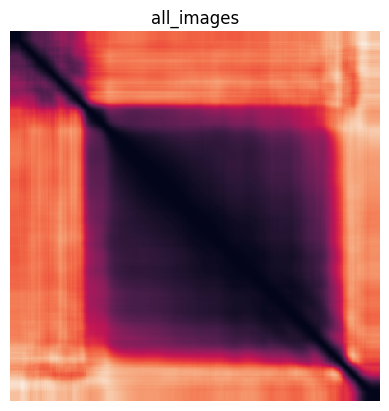

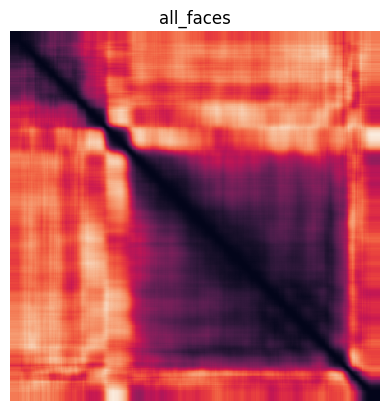

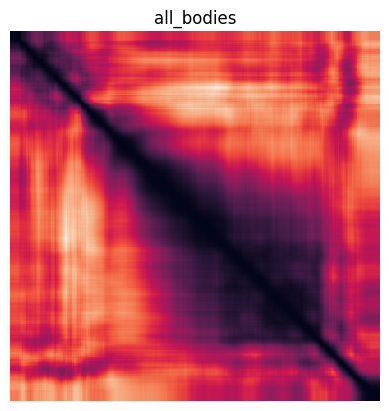

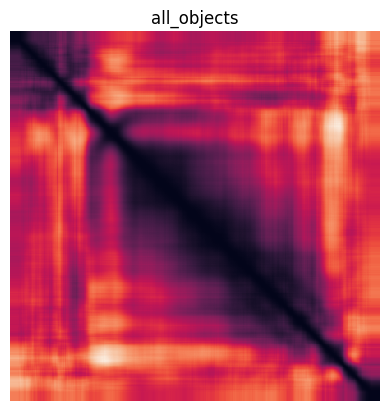

In [33]:
# GAIN RDMS
_roi = 'MF1_8_F' # MF1_8_F, Unknown_19_F, MF1_7_F
img_sets = {
    'all_images': np.arange(1000, 1072),
    "all_faces":  np.arange(1000, 1024),
    # 'monkey faces':  np.concatenate([np.arange(1000,1006), np.arange(1009,1016)]),
    # 'human faces': np.concatenate([np.arange(1006,1009), np.arange(1016,1025)]),
    "all_bodies": np.concatenate([
        np.arange(1025, 1031),
        np.arange(1042, 1048),
        np.arange(1049, 1061)
    ]),
    "all_objects": np.concatenate([
        np.arange(1024,1025),
        np.arange(1031, 1042),
        np.arange(1048,1049),
        np.arange(1061, 1072)
    ])
}

rdms = gain(dat, _roi, img_sets)

for k,v in rdms.items():
    fig,ax = plt.subplots(1,1)
    sns.heatmap(v, square = True, cbar=False, ax=ax)
    ax.set_axis_off()
    ax.set_title(k)
    plt.show()

In [10]:
rdms['all_faces'].shape

(450, 450)

In [19]:
# CALCULATE TiXTi for a region
_roi = 'MF1_8_F'
_mode = 'top'
_step = 1

sizes, rdms_top = geo_rdm(dat, _roi, mode=_mode, step=_step)

  0%|                                                                                                                                                                           | 0/200 [00:00<?, ?it/s]/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/scipy/spatial/distance.py:139: RuntimeWarning: Mean of empty slice.
  X2 = X - X.mean(axis=1, keepdims=True)
/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 16%|█████████████████████████                                                                                                                                         | 31/200 [00:05<00:27,  6.09it/s]


KeyboardInterrupt: 

In [ ]:
# PLOT TiXTi HEATMAPS for increasing number of images (50)

fig,axes = plt.subplots(10,5, figsize = (20,30), sharex=True, sharey=True)
axes = axes.ravel()

multiplier = 0
for i in range(50):
    ax = axes[i]
    
    rdm = rdms_top[i + 50*multiplier]
    sns.heatmap(rdm, cbar=False, square=True, ax=ax)
    
    ax.set_axis_off()
    ax.set_title(f'{i + 50*multiplier}')
plt.show()

In [ ]:
mds = MDS(n_components=3, n_init=2, dissimilarity='precomputed', random_state=0)

for rdm in rdms_top[3:50]:
    X = mds.fit_transform(rdm)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=sns.color_palette('Reds', X.shape[0]), s=10)
    plt.show()
    
    # triu = np.triu_indices_from(rdm, k=1)

In [ ]:
_roi = 'Unknown_19_F'
_mode = 'top'
_step = 1

sizes2, rdms_top2 = geo_rdm(dat, _roi, mode=_mode, step=_step)

In [ ]:
sig = dat[dat['p_value'] < 0.05]
df = sig[sig['roi'] == _roi]
X = np.stack(df['img_psth'].to_numpy())

# sort by top images
scores = np.nanmean(X[:, RESP, :], axis=(0,1)) - np.nanmean(X[:, BASE, :], axis=(0,1))
order = np.argsort(scores)[::-1]

sizes = [k for k in range(1, 200)]
rdvs = []
for k in tqdm(sizes):
    idx = order[:k]
    Ximg = X[:, :, idx]
    
    t = 10
    x = pdist(Ximg[:, t, :].T, metric='correlation')
    print('single time point rdm:', squareform(x).shape)
    print(Ximg.shape)
    if k > 10:
        break
    all_rdms = [pdist(Ximg[:, t, :].T, metric='correlation') for t in range(Ximg.shape[1])]
    all_rdms = np.array(all_rdms)
    print('all time point rdms:', all_rdms.shape)

In [ ]:
n_img = 40

t_start = 70
t_end = 140
rd = rdvs2[n_img]

rdm = np.mean(rd[t_start:t_end], axis=0)
rdm = squareform(rdm)

sns.heatmap(rdm)
plt.show()

In [ ]:
fig,axes = plt.subplots(10,10, figsize = (10,10), sharex=True, sharey=True)
axes = axes.ravel()

multiplier = 0
for i in range(100):
    ax = axes[i]
    
    rdm = rdms_top2[i + 100*multiplier]
    sns.heatmap(rdm, cbar=False, square=True, ax=ax)
    
    ax.set_axis_off()
    ax.set_title(f'{i + 100*multiplier}')
plt.show()

In [ ]:
mds = MDS(n_components=3, n_init=2, dissimilarity='precomputed', random_state=0)

for rdm in rdms_top[3:50]:
    X = mds.fit_transform(rdm)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=sns.color_palette('Reds', X.shape[0]), s=10)
    plt.show()
    
    # triu = np.triu_indices_from(rdm, k=1)

In [ ]:
roi = 'Unknown_19_F'
mode = 'top'

rng = np.random.default_rng(RAND)
sig = dat[dat['p_value'] < 0.05]
df = sig[sig['roi'] == roi]
if len(df) == 0:
    raise ValueError(f"No data for ROI {ROI}")
X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

scores = np.nanmean(X[:, RESP, :], axis=(0,1)) - np.nanmean(X[:, BASE, :], axis=(0,1))
order = np.argsort(scores)[::-1] if mode == 'top' else rng.permutation(scores.size)


IMG_DIR = '../../datasets/NNN/NSD1000_LOC/'

fig,axes = plt.subplots(10,10, figsize = (10,10))
axes = axes.ravel()
for idx, imgid in enumerate(order[0:100]):
    if imgid>1000:
        subpath = f'MFOB{(imgid-1000):03d}.bmp'
    else: 
        subpath = f'{imgid:04d}.bmp'
    ax = axes[idx]
    img_pth = os.path.join(IMG_DIR, subpath)
    img = mpimg.imread(img_pth)
    ax.imshow(img)
    ax.set_axis_off()
plt.show()

In [ ]:
print(f'{order[0]:04d}')